In [1]:
!pip install langchain_community langchain langgraph langchain-openai openai tavily-python

In [2]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [3]:
from pydantic import BaseModel, Field
from typing import List, Optional, Dict

class CodeInput(BaseModel):
    code: str = Field(..., description="The code provided by the user to be analyzed and optimized")
    programming_language: str = Field(..., description="The programming language of the provided code (e.g., Python, Java, etc.)")
    is_ai_related: bool = Field(None, description="Indicates if the code is related to AI, for researching design patterns using Tavily if applicable")
    context: str = Field(None, description="Optional context or description of the problem the code is addressing")

class CodeEvaluation(BaseModel):
    works: bool = Field(..., description="Indicates if the code works as expected")
    errors: Optional[List[str]] = Field(None, description="List of errors or issues found in the code execution")

class RefactoringSuggestions(BaseModel):
    suggestions: List[str] = Field(..., description="List of specific refactoring suggestions for improving the code")
    rationale: List[str] = Field(..., description="Explanation for each refactoring suggestion")

class DesignPatternResearch(BaseModel):
    design_pattern_applicable: bool = Field(..., description="Indicates if a design pattern could be applied to the code")
    pattern_name: Optional[str] = Field(None, description="Name of the design pattern that can be applied, if applicable")
    resources_found: Optional[Dict[str, str]] = Field(None, description="Links or references to external resources if research was done using Tavily")

class QualityAttributesApplication(BaseModel):
    attributes_applied: List[str] = Field(..., description="List of software quality attributes applied (e.g., SOLID principles, DRY, etc.)")
    improvements_achieved: List[str] = Field(..., description="Explanation of how each quality attribute improved the code")

class CodeOutput(BaseModel):
    optimized_code: str = Field(..., description="The optimized version of the provided code after processing")

In [4]:
from typing import Dict, TypedDict, Optional

class GraphState(TypedDict):
    code: str
    programming_language: str
    is_ai_related: bool
    context: str

    code_evaluation: CodeEvaluation

    refactoring_suggestions: RefactoringSuggestions

    design_pattern_research: DesignPatternResearch

    quality_attributes_application: QualityAttributesApplication

    optimized_code: CodeOutput

In [5]:
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)

In [6]:
from langchain_openai import ChatOpenAI
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

chat_openai_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

In [7]:
from langchain_core.output_parsers import JsonOutputParser

def code_evaluation(state):
    json_parser = JsonOutputParser(pydantic_object=CodeEvaluation)

    messages = [
        SystemMessage(content=f"You are an expert in analyzing {state['programming_language']} code."),
        HumanMessage(content=f"""
        Analyze the following {state['programming_language']} code for syntax errors and logical issues:

        {state['code']}

        Context: {state.get('context', 'No additional context provided.')}

        Step-by-step reasoning:
        1. Check for syntax errors.
        2. Identify any logical issues.
        3. Determine if the code works correctly.

        The code is AI-related: {'Yes' if state['is_ai_related'] else 'No'}

        Provide a brief evaluation, listing errors, if any, and confirming if the code works as expected.

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = chat_openai_llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Code Evaluation: {parsed_result}")

    return {
        "code_evaluation": parsed_result
    }

In [8]:
def generate_refactoring_suggestions(state):
    json_parser = JsonOutputParser(pydantic_object=RefactoringSuggestions)

    evaluation_summary = f"The code works correctly: {state['code_evaluation']['works']}."
    if state['code_evaluation']["errors"]:
        evaluation_summary += f" However, the following errors were identified: {', '.join(state['code_evaluation']['errors'])}."
    else:
        evaluation_summary += " No errors were found."

    messages = [
        SystemMessage(content=f"You are an expert in refactoring {state['programming_language']} code."),
        HumanMessage(content=f"""
        Given the following {state['programming_language']} code:

        {state['code']}

        Context: {state.get('context', 'No additional context provided.')}

        Code Evaluation Results: {evaluation_summary}

        Step-by-step reasoning:
        1. Identify areas for improvement in the code, considering the evaluation results.
        2. Suggest appropriate refactoring techniques.
        3. Provide a list of actionable refactoring suggestions.

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = chat_openai_llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Refactoring Suggestions: {parsed_result}")

    return {
        "refactoring_suggestions": parsed_result,
    }

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent

def research_design_pattern(state):
    search = TavilySearchResults(max_results=2)
    tools = [search]
    agent_executor = create_react_agent(chat_openai_llm, tools)

    json_parser = JsonOutputParser(pydantic_object=DesignPatternResearch)

    refactoring_summary = f"The following refactoring suggestions were provided: {', '.join(state['refactoring_suggestions']['suggestions'])}."

    ai_related_message = f"""
    Assess whether the following code is related to AI:

    {state['code']}

    Refactoring Suggestions: {refactoring_summary}

    Is it related to AI? {'Yes' if state['is_ai_related'] else 'No'}

    If it is about AI, use Tavily to research relevant design patterns that could support this code.
    Provide detailed information about applicable design patterns.

    If not, you must not use Tavily and just analyse the code directly for suggesting design patterns in base of what you know.

    Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
    """

    messages = [
        SystemMessage(content=f"You are an expert in software design patterns, refactoring, and AI-related code."),
        HumanMessage(content=ai_related_message)
    ]

    result = agent_executor.invoke({'messages': messages})

    print(result)

    parsed_result = json_parser.parse(result["messages"][-1].content)

    print(f"Design Pattern Research: {parsed_result}")

    return {
        "design_pattern_research": parsed_result
    }

In [10]:
def apply_quality_attributes(state):
    json_parser = JsonOutputParser(pydantic_object=QualityAttributesApplication)

    if state['design_pattern_research']['design_pattern_applicable']:
        design_pattern_summary = f"A design pattern '{state['design_pattern_research']['pattern_name']}' has been suggested for this code based on AI-related research."
    else:
        design_pattern_summary = "No design pattern was applied or needed."

    refactoring_summary = f"The following refactoring suggestions were applied: {', '.join(state['refactoring_suggestions']['suggestions'])}."

    messages = [
        SystemMessage(content=f"You are an expert in software engineering and code quality improvement for {state['programming_language']} code."),
        HumanMessage(content=f"""
        Based on the following {state['programming_language']} code and its context:

        {state['code']}

        Refactoring Summary: {refactoring_summary}

        Design Pattern Research: {design_pattern_summary}

        Step-by-step reasoning:
        1. Identify which software quality attributes (e.g., SOLID principles, DRY, KISS) can be applied to improve the code.
        2. Explain how each quality attribute improves the code, with specific focus on maintainability, readability, performance, or other key aspects.
        3. Provide a clear explanation for how these quality attributes interact with the refactoring and any design patterns applied.

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = chat_openai_llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Quality Attributes Applied: {parsed_result}")

    return {
        "quality_attributes_application": parsed_result
    }

In [11]:
def generate_optimized_code(state):
    json_parser = JsonOutputParser(pydantic_object=CodeOutput)

    refactoring_summary = f"The following refactoring suggestions were applied: {', '.join(state['refactoring_suggestions']['suggestions'])}."

    if state['design_pattern_research']['design_pattern_applicable']:
        design_pattern_summary = f"A design pattern '{state['design_pattern_research']['pattern_name']}' was suggested and applied to enhance the structure of the code."
    else:
        design_pattern_summary = "No design pattern was applied or needed."

    quality_attributes_summary = f"Quality attributes such as {', '.join(state['quality_attributes_application']['attributes_applied'])} were applied to further improve the code."

    messages = [
        SystemMessage(content=f"You are an expert in code optimization for {state['programming_language']} code."),
        HumanMessage(content=f"""
        Based on the previous analysis, refactoring, and design improvements, please generate an optimized version of the following {state['programming_language']} code:

        {state['code']}

        Refactoring Summary: {refactoring_summary}

        Design Pattern Research: {design_pattern_summary}

        Quality Attributes: {quality_attributes_summary}

        Return the final optimized version of the code, taking into account all previous suggestions and improvements.

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = chat_openai_llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Optimized Code: {parsed_result}")

    return {
        "optimized_code": parsed_result
    }

In [12]:
from langgraph.graph import END

workflow.add_node("code_evaluation_node", code_evaluation)
workflow.add_node("generate_refactoring_suggestions", generate_refactoring_suggestions)
workflow.add_node("research_design_pattern", research_design_pattern)
workflow.add_node("apply_quality_attributes", apply_quality_attributes)
workflow.add_node("generate_optimized_code", generate_optimized_code)

In [13]:
workflow.set_entry_point("code_evaluation_node")

In [14]:
workflow.add_edge('code_evaluation_node', "generate_refactoring_suggestions")
workflow.add_edge('generate_refactoring_suggestions', "research_design_pattern")
workflow.add_edge('research_design_pattern', "apply_quality_attributes")
workflow.add_edge('apply_quality_attributes', "generate_optimized_code")

In [15]:
workflow.add_edge('generate_optimized_code', END)

In [16]:
app = workflow.compile()

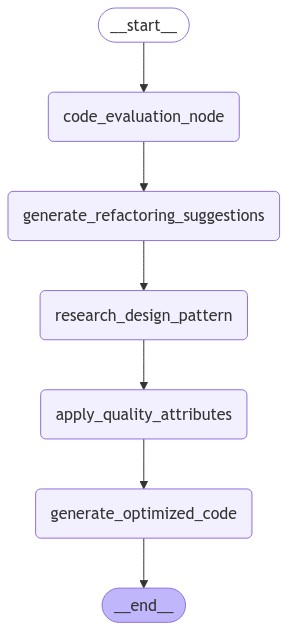

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
inputs = {
    "code": """
    def quicksort(arr):
        if len(arr) == 1:
            return arr # This will fail for an empty array, causing a crash
        pivot = arr[0]
        left = []
        right = []
        for i in arr:
            if i < pivot:
                left.append(pivot)
            else:
                right.append(pivot)
        return quicksort(left) + quicksort([pivot]) + quicksort(right)

    arr = [3, 6, 8, 10, 1, 2, 1]
    sorted_arr = quicksort(arr)
    print(sorted_arr)
    """,
    "programming_language": "python",
    "is_ai_related": False,
    "context": "This is an incorrect Quicksort algorithm that needs major refactoring and fixes."
}

result = app.invoke(inputs)

Code Evaluation: {'works': False, 'errors': ['The quicksort function does not handle an empty array, which will cause a crash.', 'The pivot element is incorrectly added to the left and right lists instead of the current element being compared.', "The logic for appending elements to the left and right lists is incorrect; it should append 'i', not 'pivot'.", "The base case should also check for an empty array, returning the array directly if it's empty."]}
Refactoring Suggestions: {'suggestions': ['Handle the case for an empty array in the base case of the quicksort function.', "Correctly append the current element 'i' to the left and right lists instead of appending 'pivot'.", 'Fix the logic to ensure that elements equal to the pivot are included in the correct segment.', 'Refactor the recursive calls to quicksort to avoid repeating the pivot element unnecessarily.'], 'rationale': ['By handling the empty array case, we prevent potential crashes when the input is an empty list.', "Append

In [19]:
result

{'code': '\n    def quicksort(arr):\n        if len(arr) == 1:\n            return arr # This will fail for an empty array, causing a crash\n        pivot = arr[0]\n        left = []\n        right = []\n        for i in arr:\n            if i < pivot:\n                left.append(pivot) \n            else:\n                right.append(pivot) \n        return quicksort(left) + quicksort([pivot]) + quicksort(right) \n    \n    arr = [3, 6, 8, 10, 1, 2, 1]\n    sorted_arr = quicksort(arr)\n    print(sorted_arr) \n    ',
 'programming_language': 'python',
 'is_ai_related': False,
 'context': 'This is an incorrect Quicksort algorithm that needs major refactoring and fixes.',
 'code_evaluation': {'works': False,
  'errors': ['The quicksort function does not handle an empty array, which will cause a crash.',
   'The pivot element is incorrectly added to the left and right lists instead of the current element being compared.',
   "The logic for appending elements to the left and right lists 

In [20]:
inputs2 = {
    "code": """
import tensorflow as tf
import numpy as np

class BadNeuralNetwork:
    def __init__(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, input_shape=(784,)),
            tf.keras.layers.Dense(32),
            tf.keras.layers.Dense(10)
        ])

    def compile(self):
        self.model.compile(optimizer=None, loss=None)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train, epochs=10)

y_train = np.random.random((100, 10))

nn = BadNeuralNetwork()

nn.compile()

nn.train(X_train, y_train)
    """,
    "programming_language": "python",
    "is_ai_related": True,
    "context": "This is a bad implementation of a neural network using TensorFlow with multiple issues including missing activation functions, optimizer, loss function, and incorrect data dimensions."
}

result2 = app.invoke(inputs2)

Code Evaluation: {'works': False, 'errors': ['Missing optimizer in model compilation.', 'Missing loss function in model compilation.', "The variable 'X_train' is not defined before use in 'nn.train(X_train, y_train)'.", 'No activation function is specified for the Dense layers, which is typically necessary for neural networks.', "The shape of 'y_train' should match the output shape of the network (10 classes), but it needs to be one-hot encoded or categorical in practice."]}
Refactoring Suggestions: {'suggestions': ['Define the optimizer and loss function in the compile method.', 'Add activation functions to the Dense layers to improve network performance.', "Ensure 'X_train' is defined with the appropriate shape and type before calling train.", "One-hot encode 'y_train' to match the output of the network.", "Use a proper data preprocessing step to prepare 'X_train' and 'y_train'."], 'rationale': ['Specifying an optimizer and loss function is essential for model training, allowing the 

In [21]:
result2

{'code': '\nimport tensorflow as tf\nimport numpy as np\n\nclass BadNeuralNetwork:\n    def __init__(self):\n        self.model = tf.keras.Sequential([\n            tf.keras.layers.Dense(64, input_shape=(784,)),  \n            tf.keras.layers.Dense(32), \n            tf.keras.layers.Dense(10) \n        ])\n\n    def compile(self):\n        self.model.compile(optimizer=None, loss=None)  \n\n    def train(self, X_train, y_train):\n        self.model.fit(X_train, y_train, epochs=10)  \n\ny_train = np.random.random((100, 10))  \n\nnn = BadNeuralNetwork()\n\nnn.compile()\n\nnn.train(X_train, y_train)\n    ',
 'programming_language': 'python',
 'is_ai_related': True,
 'context': 'This is a bad implementation of a neural network using TensorFlow with multiple issues including missing activation functions, optimizer, loss function, and incorrect data dimensions.',
 'code_evaluation': {'works': False,
  'errors': ['Missing optimizer in model compilation.',
   'Missing loss function in model com